## Download Dataset from here:

https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp


Emotion_Detection_Data/
├── train.txt
├── val.txt
└── test.txt

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import re

In [2]:
# Load data

def load_data(path):
    with open(path, encoding="utf-8") as f:
        lines = f.read().splitlines()
    texts, labels = zip(*(line.split(";") for line in lines))
    return list(texts), list(labels)

train_texts, train_labels = load_data("Emotion_Detection_Data/train.txt")
val_texts, val_labels = load_data("Emotion_Detection_Data/val.txt")
test_texts, test_labels = load_data("Emotion_Detection_Data/test.txt")

In [3]:
# Text preprocessing

def tokenize(text):
    return re.findall(r"\b\w+\b", text.lower())

all_texts = train_texts + val_texts + test_texts
vocab_counter = Counter(word for text in all_texts for word in tokenize(text))
vocab = {word: idx+2 for idx, (word, _) in enumerate(vocab_counter.most_common())}
vocab["<PAD>"] = 0
vocab["<UNK>"] = 1

def encode_text(text, max_len=50):
    tokens = tokenize(text)
    ids = [vocab.get(t, 1) for t in tokens][:max_len]
    return ids + [0] * (max_len - len(ids))

In [4]:
# Label encoding

label_enc = LabelEncoder()
label_enc.fit(train_labels)
num_classes = len(label_enc.classes_)

In [5]:
# Dataset class

class EmotionDataset(Dataset):
    def __init__(self, texts, labels):
        self.x = torch.tensor([encode_text(t) for t in texts], dtype=torch.long)
        self.y = torch.tensor(label_enc.transform(labels), dtype=torch.long)

    def __len__(self): return len(self.x)
    def __getitem__(self, idx): return self.x[idx], self.y[idx]

train_ds = EmotionDataset(train_texts, train_labels)
val_ds = EmotionDataset(val_texts, val_labels)
test_ds = EmotionDataset(test_texts, test_labels)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)

In [6]:
# Model

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        return self.fc(hidden.squeeze(0))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier(len(vocab), embed_dim=128, hidden_dim=128, output_dim=num_classes).to(device)


In [9]:
# Training

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_accs, val_accs = [], []
for epoch in range(30):
    model.train()
    total, correct = 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        preds = output.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)
    train_accs.append(correct / total)

    # Validation
    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    val_accs.append(correct / total)
    print(f"Epoch {epoch+1}: Train Acc={train_accs[-1]:.4f}, Val Acc={val_accs[-1]:.4f}")

Epoch 1: Train Acc=0.7402, Val Acc=0.7245
Epoch 2: Train Acc=0.8457, Val Acc=0.7880
Epoch 3: Train Acc=0.8978, Val Acc=0.8185
Epoch 4: Train Acc=0.9221, Val Acc=0.8280
Epoch 5: Train Acc=0.9380, Val Acc=0.8465
Epoch 6: Train Acc=0.9547, Val Acc=0.8560
Epoch 7: Train Acc=0.9611, Val Acc=0.8635
Epoch 8: Train Acc=0.9672, Val Acc=0.8525
Epoch 9: Train Acc=0.9724, Val Acc=0.8585
Epoch 10: Train Acc=0.9754, Val Acc=0.8705
Epoch 11: Train Acc=0.9815, Val Acc=0.8665
Epoch 12: Train Acc=0.9831, Val Acc=0.8710
Epoch 13: Train Acc=0.9864, Val Acc=0.8585
Epoch 14: Train Acc=0.9857, Val Acc=0.8725
Epoch 15: Train Acc=0.9888, Val Acc=0.8655
Epoch 16: Train Acc=0.9837, Val Acc=0.8790
Epoch 17: Train Acc=0.9912, Val Acc=0.8745
Epoch 18: Train Acc=0.9932, Val Acc=0.8770
Epoch 19: Train Acc=0.9924, Val Acc=0.8780
Epoch 20: Train Acc=0.9922, Val Acc=0.8615
Epoch 21: Train Acc=0.9932, Val Acc=0.8695
Epoch 22: Train Acc=0.9929, Val Acc=0.8745
Epoch 23: Train Acc=0.9942, Val Acc=0.8690
Epoch 24: Train Acc=

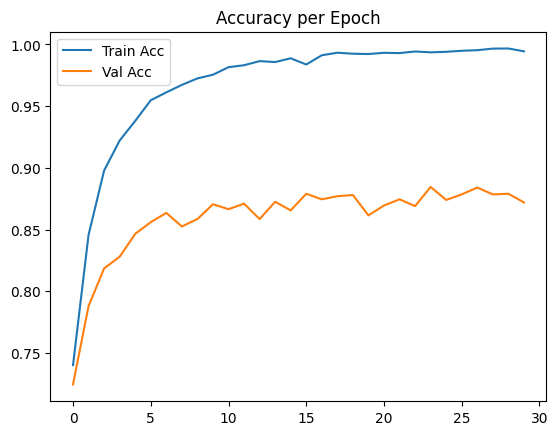

In [11]:
# Plot accuracy

plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.legend()
plt.title("Accuracy per Epoch")
plt.show()

In [12]:
# Test evaluation

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        preds = model(x).argmax(1).cpu().tolist()
        y_pred.extend(preds)
        y_true.extend(y.tolist())

print(classification_report(y_true, y_pred, target_names=label_enc.classes_))

              precision    recall  f1-score   support

       anger       0.85      0.85      0.85       275
        fear       0.88      0.87      0.87       224
         joy       0.91      0.90      0.91       695
        love       0.71      0.66      0.68       159
     sadness       0.89      0.94      0.91       581
    surprise       0.75      0.67      0.70        66

    accuracy                           0.87      2000
   macro avg       0.83      0.81      0.82      2000
weighted avg       0.87      0.87      0.87      2000



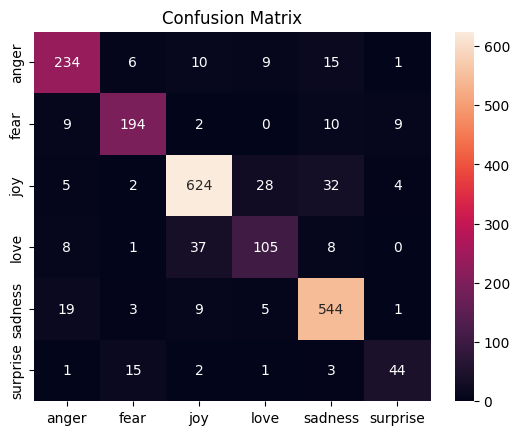

In [13]:
# Confusion Matrix 

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_enc.classes_, yticklabels=label_enc.classes_)
plt.title("Confusion Matrix")
plt.show()